# Autoencoder MNIST

## Importing required packages

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from  torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim
from torchvision import datasets,transforms

## Defining transforms

In [2]:
transforms=transforms.ToTensor()

## Downloading requried data

In [3]:
train_data=datasets.MNIST('data',train=True,download=True,transform=transforms)
test_data=datasets.MNIST('data',train=False,download=True,transform=transforms)

## Defining dataloaders

In [4]:
valid_size=0.2

# IMPORTANT 
batch_size=20

num_workers=0

train_length = len(train_data)

# obtain training dataset indices that will be used for validation dataset
indices = list(range(train_length))

np.random.shuffle(indices)
split = int(np.floor(valid_size * train_length))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders for train, test and validation dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [5]:

# Printing the length of our train, valid and test dataloaders
# NOTE : Here batch size is 20
len(train_loader),len(valid_loader),len(test_loader)

(2400, 600, 500)

In [6]:
# checking our data
dataiter=iter(train_loader)
images,labels=dataiter.next()
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

## Visualizing a Training batch

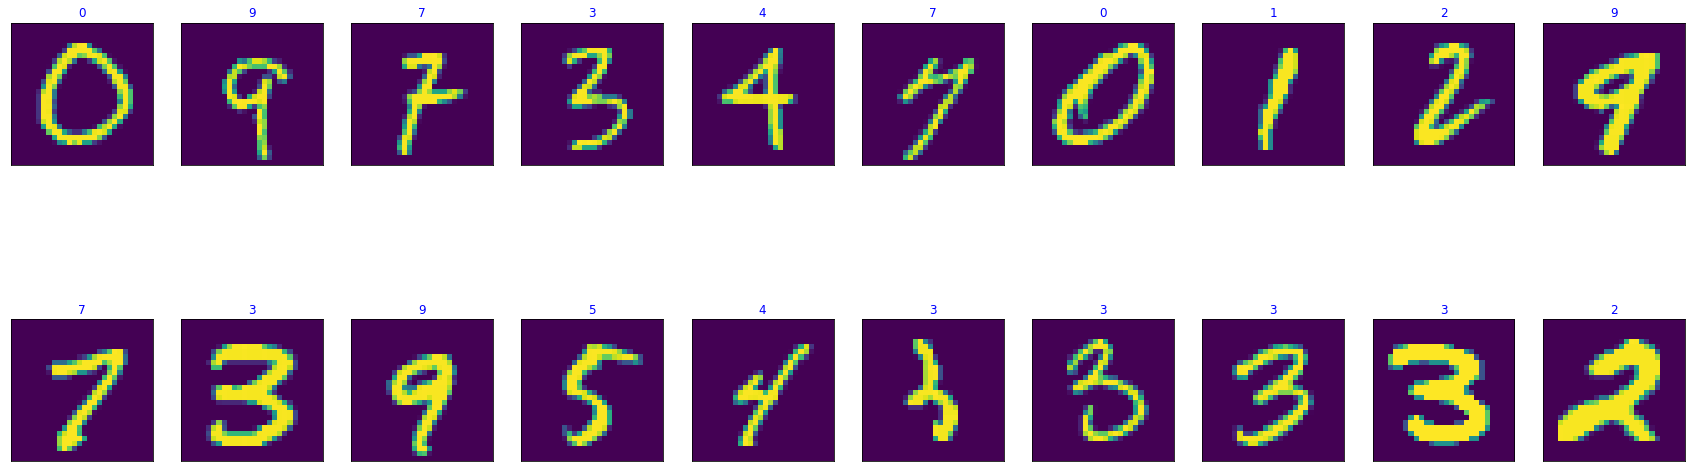

In [7]:
# Displaying images and labels of a batch
fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(labels[i].item(),color='blue')

## Defining Architecture

In [8]:
class F_Auto_MNIST(nn.Module):
    def __init__(self,en_dim):
        super(F_Auto_MNIST,self).__init__()
        self.encoder=nn.Linear(784,en_dim)
        self.decoder=nn.Linear(en_dim,784)
    
    def forward(self,x):
        x=F.relu(self.encoder(x))
        x=F.sigmoid(self.decoder(x))
        return x

class Tran_conv_Auto_MNIST(nn.Module):
    def __init__(self):
        super(Tran_conv_Auto_MNIST,self).__init__()
        self.en_conv1=nn.Conv2d(1,16,3,padding=1)
        self.en_conv2=nn.Conv2d(16,4,3,padding=1)
        self.pool=nn.MaxPool2d(2,2)

        self.de_conv1=nn.ConvTranspose2d(4,16,2,stride=2)
        self.de_conv2=nn.ConvTranspose2d(16,1,2,stride=2)

    def forward(self,x):
        x=self.pool(F.relu(self.en_conv1(x)))
        x=self.pool(F.relu(self.en_conv2(x)))
        x=F.relu(self.de_conv1(x))
        x=F.sigmoid(self.de_conv2(x))
        return x

class upsamp_conv_Auto_MNIST(nn.Module):
    def __init__(self):
        super(upsamp_conv_Auto_MNIST,self).__init__()
        self.en_conv1=nn.Conv2d(1,16,3,padding=1)
        self.en_conv2=nn.Conv2d(16,4,3,padding=1)
        self.pool=nn.MaxPool2d(2,2)

        self.de_conv1=nn.Conv2d(4,16,3,padding=1)
        self.de_conv2=nn.Conv2d(16,1,3,padding=1)

    def forward(self,x):
        x=self.pool(F.relu(self.en_conv1(x)))
        x=self.pool(F.relu(self.en_conv2(x)))
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x=F.relu(self.de_conv1(x))
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x=F.sigmoid(self.de_conv2(x))
        return x

#Since the images are normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range.

In [9]:
model_1=F_Auto_MNIST(32)
model_2=Tran_conv_Auto_MNIST()
model_3=upsamp_conv_Auto_MNIST()

def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

model_1.apply(weight_init_normal)

use_cuda=True
if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  model_2.cuda()
  model_3.cuda()
print(model_1,'\n\n\n\n',model_2,'\n\n\n\n',model_3,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

F_Auto_MNIST(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Linear(in_features=32, out_features=784, bias=True)
) 



 Tran_conv_Auto_MNIST(
  (en_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (en_conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (de_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (de_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
) 



 upsamp_conv_Auto_MNIST(
  (en_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (en_conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (de_conv1): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (de_conv2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
) 



 O

## Defining our Loss Function

In [10]:
# Used when comapring pixel values.
criterion=nn.MSELoss()

## Training and Validation Phase

In [11]:
def trainNet(model,lr,state='fully'):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)

    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    epochs=20

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf 

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,_ in train_loader:
            if use_cuda and torch.cuda.is_available():
                images=images.cuda()
            if state=='fully':
                images=images.view(images.size(0),-1)
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,images)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,_ in valid_loader:
            if use_cuda and torch.cuda.is_available():
                images=images.cuda()
            if state=='fully':
                images=images.view(images.size(0),-1)
            output=model(images)
            loss=criterion(output,images)
            valid_loss+=loss.item()

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z=type(model).__name__
            torch.save(model.state_dict(), z+'_model.pth')
            valid_loss_min=valid_loss
    return(loss_keeper)

In [12]:
m1_loss=trainNet(model_1,0.01)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1791: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epoch : 1	Training Loss : 0.02896550076858451	Validation Loss : 0.02558390931536754
Validation loss decreased from : inf ----> 0.02558390931536754 ----> Saving Model.......

Epoch : 2	Training Loss : 0.025176408106150728	Validation Loss : 0.02528782489709556
Validation loss decreased from : 0.02558390931536754 ----> 0.02528782489709556 ----> Saving Model.......

Epoch : 3	Training Loss : 0.024819760410270342	Validation Loss : 0.025184290970986088
Validation loss decreased from : 0.02528782489709556 ----> 0.025184290970986088 ----> Saving Model.......

Epoch : 4	Training Loss : 0.024684938127951077	Validation Loss : 0.024978625137979785
Validation loss decreased from : 0.025184290970986088 ----> 0.024978625137979785 ----> Saving Model.......

Epoch : 5	Training Loss : 0.02461117018557464	Validation Loss : 0.024704792660971482
Validation loss decreased from : 0.024978625137979785 ----> 0.024704792660971482 ----> Saving Model.......

Epoch : 6	Training Loss : 0.02453265693426753	Validati

In [13]:
m2_loss=trainNet(model_2,0.01,'conv')


Epoch : 1	Training Loss : 0.03177310996611292	Validation Loss : 0.02294422238133848
Validation loss decreased from : inf ----> 0.02294422238133848 ----> Saving Model.......

Epoch : 2	Training Loss : 0.022251348613838977	Validation Loss : 0.021716179943953952
Validation loss decreased from : 0.02294422238133848 ----> 0.021716179943953952 ----> Saving Model.......

Epoch : 3	Training Loss : 0.021415203340584412	Validation Loss : 0.021288092794517675
Validation loss decreased from : 0.021716179943953952 ----> 0.021288092794517675 ----> Saving Model.......

Epoch : 4	Training Loss : 0.02102814870653674	Validation Loss : 0.020969783617183567
Validation loss decreased from : 0.021288092794517675 ----> 0.020969783617183567 ----> Saving Model.......

Epoch : 5	Training Loss : 0.020830238189082594	Validation Loss : 0.020881876127483944
Validation loss decreased from : 0.020969783617183567 ----> 0.020881876127483944 ----> Saving Model.......

Epoch : 6	Training Loss : 0.02071243806509301	Valid

In [14]:
m3_loss=trainNet(model_3,0.01,'conv')

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3437: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")



Epoch : 1	Training Loss : 0.1121672908992817	Validation Loss : 0.11204921410729488
Validation loss decreased from : inf ----> 0.11204921410729488 ----> Saving Model.......

Epoch : 2	Training Loss : 0.11199091531336308	Validation Loss : 0.11204921394586563
Validation loss decreased from : 0.11204921410729488 ----> 0.11204921394586563 ----> Saving Model.......

Epoch : 3	Training Loss : 0.11199091541891297	Validation Loss : 0.1120492144053181

Epoch : 4	Training Loss : 0.11199091523885726	Validation Loss : 0.112049213933448
Validation loss decreased from : 0.11204921394586563 ----> 0.112049213933448 ----> Saving Model.......

Epoch : 5	Training Loss : 0.11199091527611017	Validation Loss : 0.1120492139707009

Epoch : 6	Training Loss : 0.11199091535372038	Validation Loss : 0.11204921375960111
Validation loss decreased from : 0.112049213933448 ----> 0.11204921375960111 ----> Saving Model.......

Epoch : 7	Training Loss : 0.11199091545616587	Validation Loss : 0.11204921414454778

Epoch : 8

In [15]:
model_1.load_state_dict(torch.load('F_Auto_MNIST_model.pth'))
model_2.load_state_dict(torch.load('Tran_conv_Auto_MNIST_model.pth'))
model_3.load_state_dict(torch.load('upsamp_conv_Auto_MNIST_model.pth'))

<All keys matched successfully>

## Plotting Loss

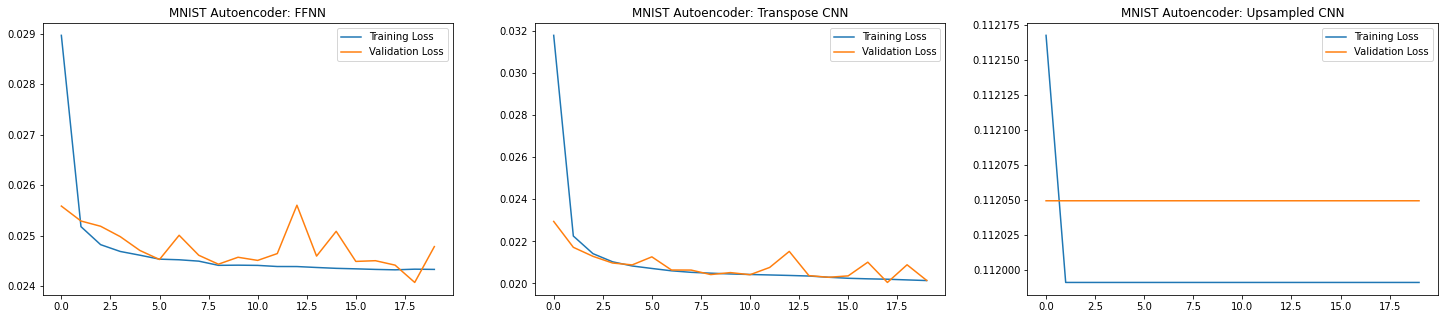

In [16]:
title=['FFNN','Transpose CNN','Upsampled CNN']
model_losses=[m1_loss,m2_loss,m3_loss]

fig=plt.figure(1,figsize=(25,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,3,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title('MNIST Autoencoder: '+title[idx-1])
  idx+=1
  plt.legend();

## Testing Phase

In [20]:
# 예제로 MSE를 사용하여 유사성을 계산하는 함수
def calculate_similarity(img1, img2):
    criterion = torch.nn.MSELoss()
    loss = criterion(img1, img2)
    return -loss.item()  # Negative loss because higher similarity corresponds to lower loss


In [24]:
def test(model,state='fully'):
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, _ = dataiter.next()
    if use_cuda and torch.cuda.is_available():
        images=images.cuda()
    if state=='fully':
        images = images.view(images.size(0), -1)

    # 전처리된 이미지를 모델에 전달하여 재구성 이미지 생성
    with torch.no_grad():
        output = model(images)

    # 유사도 측정 (예: MSE를 사용하여 유사성 계산)
    similarity_scores = []
    for reconstructed_img in output:
        reconstructed_img = torch.unsqueeze(torch.from_numpy(reconstructed_img), dim=0)  # NumPy 배열을 PyTorch 텐서로 변환하여 unsqueeze 사용
        font_img_tensor = torch.unsqueeze(torch.from_numpy(images), dim=0)  # NumPy 배열을 PyTorch 텐서로 변환하여 unsqueeze 사용
        similarity_score = calculate_similarity(reconstructed_img, font_img_tensor)  # calculate_similarity 함수는 유사도를 측정하는 함수
        similarity_scores.append(similarity_score)


    # 시각화
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            if state=='fully':
                img = img.view(1, 28, 28)
            ax.imshow(np.squeeze(img.cpu().numpy()), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

    return similarity_scores

## FFNN Autoencoder

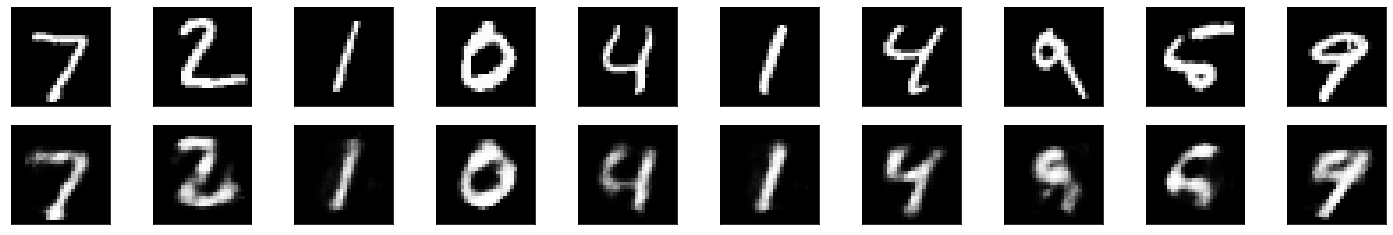

In [20]:
test(model_1)

## Transpose CNN Autoencoder

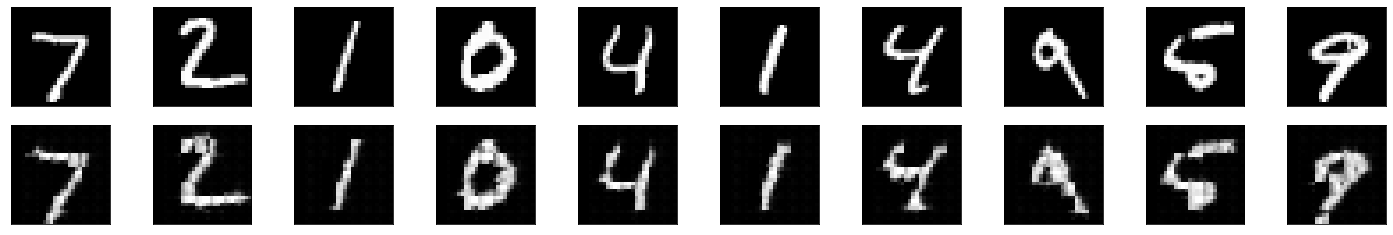

In [18]:
test(model_2,'conv')

## Upsampled CNN Autoencoder

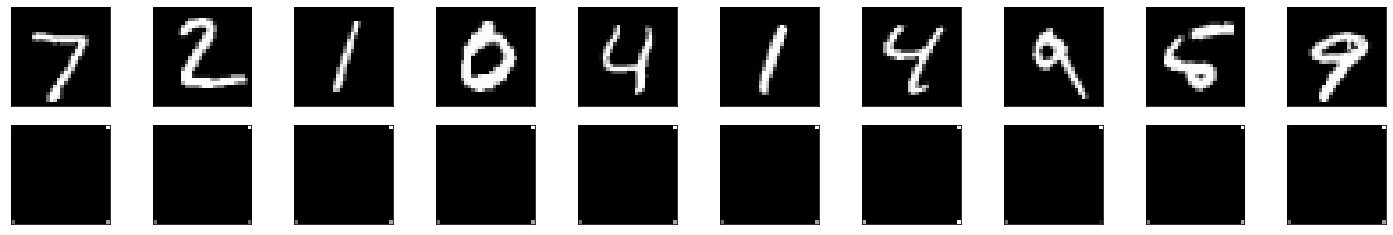

In [19]:
test(model_3,'conv')

In [25]:
font_img = np.random.rand(28, 28)  # 예시로 랜덤한 이미지 생성
font_img = (font_img * 255).astype(np.uint8)

# 모델 생성 예시
# model = your_model_here

# 모델 테스트 및 유사도 측정
similarity_scores = test(model_2, 'conv')
print("Similarity Scores:", similarity_scores)

TypeError: expected np.ndarray (got Tensor)